In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i,s in enumerate(chars) }
s2i['.'] = 0 # special for Start or End
i2s = {i:s for s,i in s2i.items()}

In [4]:
block_size = 3
def build_ds(words):
     # how many chars do w etake to predict the next one
    xs, ys = [], []
    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w+'.':
            ix = s2i[ch]
            (xs.append(context), ys.append(ix))
            # print(''.join(i2s[i] for i in context), ' ---> ', ch)
            context = context[1:] + [ix] # note this context doesn't become part of the training set, because it is like ma. -> and always leads to .
     # X is say 32 x 3       
    return torch.tensor(xs), torch.tensor(ys) 

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_ds(words[:n1])
Xdev, Ydev = build_ds(words[n1:n2])
Xte, Yte = build_ds(words[n2:])

In [11]:
g = torch.Generator().manual_seed(2147483647)
# Lookup table - same for all three members of context
embedding = 20
hidden = 200
# we should start from Uniform, not random
# since we have no reason to believe any char is more likely than the other
torch.tensor(1/27).log()
C = torch.randn((27,embedding), generator=g)


# eg 6 because we have 3 in context and 2 embeddings (columns of C) for each of the 3.
W1 = torch.randn((embedding*block_size,hidden), generator=g) * 5/3/(embedding*block_size)**0.5 # see kaiming init
# b1 = torch.randn(hidden, generator=g) * 0.01 not needed since we use datch normalisation (bnmean_running)
# Note: roughly Normal W -> roughly Normal output


W2 = torch.randn((hidden,27), generator=g) * 0.01 # 27 chars is the output
b2 = torch.randn(27, generator=g) * 0 #should be 0 at initialisation to ensure uniform dist at init

bngain = torch.ones((1,hidden))
bnbias = torch.zeros((1,hidden))
bnmean_running = torch.zeros((1,hidden))
bnstd_running = torch.ones((1,hidden))


parameters = [C, W2, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad=True

In [62]:
# see below for better way(batches)
for _ in range(1):
    # One hot[0,1,0] x MxM is same as picking row 2 from M
    # but we have 3 items in context, not just 1, so PICK ALL 3 ROWS from C
    # C[X] gives 32 of 3 of C's rows, ie [32, 3, 2]
    emb = C[X]
    # roughly want this emb@W1 + b1
    # to do this emb must be 32x6 (instead of 32x3x2)
    h = torch.tanh(emb.view(-1,6)@W1+b1) #32x100
    logits = h@W2+b2
    # -- BEFORE
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    ## probs[torch.arange(5), Y] #want to maximise that
    # loss = - probs[torch.arange(32), Y].log().mean() # eq want to minimize that
    # loss
    # -- AFTER (equivallent)
    loss = F.cross_entropy(logits, Y) 
    # print(loss)
    # Forward pass is much more efficient - no copying data
    # Backward pass is much more efficient - backward function is derived and hardcoded analytically
    # Well behaved: internally torch does logits=logits-max(logits) to avoid logits.exp() blowing up
    
    for p in parameters:
        p.grad=None
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad

print(loss.item())

2.9267003536224365


In [6]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [12]:
# In practice forward and backward in batches
# Works better in practice than whole batch at time
lri, lossi, stepi = [], [], []
max_steps = 200_000
for i in range(max_steps):
    # One hot[0,1,0] x MxM is same as picking row 2 from M
    # but we have 3 items in context, not just 1, so PICK ALL 3 ROWS from C
    # C[X] gives 32 of 3 of C's rows, ie [32, 3, 2]
    ix = torch.randint(0, Xtr.shape[0], (32,)) # 32 rand ints from 0 to NofXs - 32 is the batch size
    emb = C[Xtr[ix]] # only ix rows of X
    # roughly want this emb@W1 + b1
    # to do this emb must be 32x6 (instead of 32x3x2)
    # -1 means leave it up to torch to determine
    # Note: If x is very large in tanh(x), then tanh(x) is 1 or -1, and in that region
    # it's derivative is 0! Hence bad learning. And if all Neurons' row derivatives are ~0 derivative - then it's a dead Neuron
    # SO WE WANT EMB to be close to 0
    hpreact = emb.view(-1,embedding*block_size)@W1 #+b1
    # --- BATCH NORMALIZATION
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact - bnmeani)/bnstdi + bnbias
    with torch.no_grad(): # mean update off graph
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    # --- In practice use Group/Layer Normalisation
    
    h = torch.tanh(hpreact) #32x100
    logits = h@W2+b2
    # -- BEFORE
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    ## probs[torch.arange(5), Y] #want to maximise that
    # loss = - probs[torch.arange(32), Y].log().mean() # eq want to minimize that
    # loss
    # -- AFTER (equivallent)
    loss = F.cross_entropy(logits, Ytr[ix]) 

    # Forward pass is much more efficient - no copying data
    # Backward pass is much more efficient - backward function is derived and hardcoded analytically
    # Well behaved: internally torch does logits=logits-max(logits) to avoid logits.exp() blowing up
    
    for p in parameters:
        p.grad=None
    loss.backward()
    # lr = lrs[i]
    lr = 0.1 if i<100_000 else 0.01
    # Learning rate decay - in the later stages of training - dicrease LR!
    for p in parameters:
        p.data += -lr*p.grad

    #track
    # lri.append(lre[i])
    # lossi.append(loss.item())
    # stepi.append(i)
    if i%10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

print(loss.item())

      0/ 200000: 3.3017
  10000/ 200000: 1.9519
  20000/ 200000: 2.1871
  30000/ 200000: 2.0627
  40000/ 200000: 2.2849
  50000/ 200000: 2.2838
  60000/ 200000: 2.9502
  70000/ 200000: 2.4248
  80000/ 200000: 2.2393
  90000/ 200000: 2.2476
 100000/ 200000: 2.1544
 110000/ 200000: 2.2581
 120000/ 200000: 1.8574
 130000/ 200000: 2.3195
 140000/ 200000: 2.3300
 150000/ 200000: 2.5288
 160000/ 200000: 2.5199
 170000/ 200000: 2.2824
 180000/ 200000: 2.4517
 190000/ 200000: 1.9058
2.055640935897827


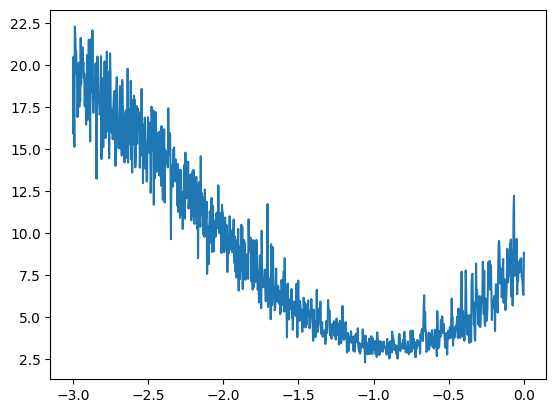

In [69]:
# How to determine reasonable learning rate?
plt.plot(lri, lossi) # so -1.0 is a good lre => 10^(-1)=0.1 is a good learning rate
# Also, IN PRODUCTION, run expirements, different combinations

In [ ]:
# train - 80% - to optimize params - usually split into batches
# dev/validation - 10% - to optimize hyper params
# test - 10% - to eval results
# IF dev and test losses are roughly equal - then increase the size of the NN

In [14]:
# eval loss - disable grad tracking, no bookkeeping,
# "I will not call ".backward"
@torch.no_grad()
def split_loss(X, Y):
    emb = C[X] # only ix rows of X
    hpreact = emb.view(emb.shape[0],-1)@W1 #+b1
    # Mini batch normalisation - see google paper:
    # assuming N(mean, std) dist of hpreact, below will be N(0,1), which is what we want for tanh
    hpreact = bngain*(hpreact - bnmean_running)/bnstd_running + bnbias # bngain and bnbias will be trained
    h = torch.tanh(hpreact) #32x100
    logits = h@W2+b2
    loss = F.cross_entropy(logits, Y) 
    print(loss.item())
print('train')
split_loss(Xtr, Ytr)
print('dev')
split_loss(Xdev, Ydev)
print('test')
split_loss(Xte, Yte)

train
2.1803531646728516
dev
2.192589282989502
test
2.1906514167785645


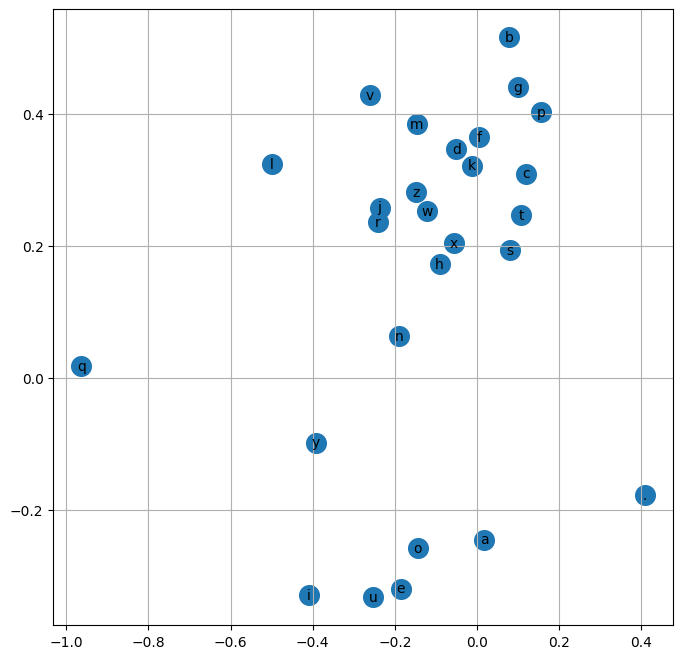

In [96]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), i2s[i], ha='center', va='center')
plt.grid('minor')

In [106]:
# SAMPLING
ix = 0 #row (ie first char)
for i in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])] # select the 3 rows of C (eg 1x3x20)
        h = torch.tanh(emb.view(1,-1)@W1+b1) #W1 is 60x200. put together emb into 1x60 (instead of 1x3x20)
        logits = (h@W2 + b2) # due to 1hot this is same as picking row ix from W
        p = F.softmax(logits,dim=1)
        # --
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(i2s[i] for i in out))

tzee.
mesodli.
any.
amela.
jeruandrima.
milah.
torahenrikai.
aarileen.
zya.
skado.
namiya.
evelan.
kirtayda.
kayya.
azsheuhi.
mori.
ilyi.
zyn.
aleahnielriden.
hadde.


In [116]:
h = emb.view(-1,embedding*block_size)@W1+b1
print(Xtr[0])
print(Ytr[0])



tensor([0, 0, 0])
tensor(20)
